In [1]:
from pathlib import Path
wd = Path.cwd()
wd = wd.parent.parent
wd = wd / 'merged_data'
sub1 = str(wd) + '/subtask1.parquet'
print(sub1)

/home/matijak/Documents/programiranje/projects/semeval/merged_data/subtask1.parquet


In [2]:
import pandas as pd
df = pd.read_parquet(sub1)

In [3]:
import re
def labelNum(row):
    if row['class1'] == 'Antagonist':
        return int(0)
    if row['class1'] == 'Innocent':
        return int(1)
    if row['class1'] == 'Protagonist':
        return int(2)
def cleanText(row):
    text = str(row['text'])
    #text = re.sub(r'[^\w\s]', ' ', text)
    text = text.replace('\n',' ').replace('  ', ' ')
    return text
df['label'] = df.apply(labelNum,axis=1)
df['input'] = df.apply(cleanText,axis=1)

In [19]:
def find_all_substring_start_end(text, substring):
    # Use re.finditer to find all occurrences of the substring in the text
    matches = re.finditer(re.escape(substring), text)

    # Collect the start and end indices of all matches
    positions = [(match.start(), match.end()) for match in matches]

    return positions
def adjust_start_end(row):
    org_text,cl_text,start,end,entity = str(row['text']),str(row['input']),int(row['start']),int(row['end']),str(row['entity'])
    ss1 = find_all_substring_start_end(org_text,entity)
    ss2 = find_all_substring_start_end(cl_text,entity)
    #print(ss1,ss2)
    #print(row['text'][start:end])
    a = 0
    for i in range(len(ss1)):
        if abs((ss1[i][0] - start) + (ss1[i][1] - end) ) <= 2:
            a = i
            break
    if org_text[ss1[a][0]:ss1[a][1]] != cl_text[ss2[a][0]:ss2[a][1]]:
        print("ERROR!")
    return ss2[a][0],ss2[a][1]
df['new_start_end'] = df.apply(adjust_start_end,axis=1)
print(df.loc[0])
print(df.loc[1000])

lang                                                            BG
art_name                                                BG_670.txt
entity                                                       Запад
start                                                          152
end                                                            156
class1                                                  Antagonist
classes2              [Conspirator, Instigator, Foreign Adversary]
text             Опитът на колективния Запад да „обезкърви Руси...
label                                                            0
input            Опитът на колективния Запад да „обезкърви Руси...
new_start_end                                           (151, 156)
span_input       Опитът на колективния Запад да „обезкърви Руси...
Name: 0, dtype: object
lang                                                            HI
art_name                                                HI_129.txt
entity                                 

In [5]:
def addTokensToInput(row):
    inp = row['input']
    start,end = row['new_start_end']
    #print(start,end)
    start = int(start)
    end = int(end)
    token_input = inp[:start] + "[SPAN_START] " + inp[start:end] + " [SPAN_END]" + inp[end:]
    return token_input

df['span_input'] = df.apply(addTokensToInput,axis=1)

In [6]:
def upStartEnd(row):
    start,end = row['new_start_end']
    start += len("[SPAN_START] ")
    end += len("[SPAN_START] ")
    return start,end

df['new_start_end'] = df.apply(upStartEnd,axis = 1)

In [7]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from transformers import XLMRobertaForSequenceClassification, XLMRobertaTokenizerFast

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=3).to(device)
tokenizer = XLMRobertaTokenizerFast.from_pretrained("xlm-roberta-base")

def preprocess_function(examples):
    return tokenizer(examples['span_input'], padding=True, truncation=True,max_length=8192,return_offsets_mapping=True)

Using device: cuda


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
extraTokens = {
    "additional_special_tokens": ["[SPAN_START]", "[SPAN_END]"]
}
num_added_toks = tokenizer.add_special_tokens(extraTokens)
model.resize_token_embeddings(len(tokenizer))

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(250004, 768, padding_idx=1)

In [9]:
data = df.loc[ : , ['span_input','label','new_start_end','entity']]
data['tokenized']=data.apply(preprocess_function,axis=1)

In [10]:
def indexes(row):
    off_mask = row['tokenized']['offset_mapping']
    start,end = row['new_start_end'][0],row['new_start_end'][1]
    inds = list()
    for p in range(len(off_mask)):
        if off_mask[p][0] >= start and off_mask[p][1] <= end:
            if p != len(off_mask)-1:
                inds.append(p)
    #if len(inds) > 1:
        #print("GREATER THAN 1")
    if len(inds) == 0:
        print(start,end)
    return inds
data['indexes'] = data.apply(indexes,axis=1)

In [11]:
data['list'] = data['tokenized'].apply(lambda x: x['input_ids'])
data['attention'] = data['tokenized'].apply(lambda x: x['attention_mask'])
ids = data['list']
att = data['attention']
indexes = data['indexes']
tids = list()
tatt = list()
print(len(ids),len(att),len(indexes))
for i in range(len(ids)):
    tids.append(torch.tensor(ids[i]))
    tatt.append(torch.tensor(att[i]))

2902 2902 2902


In [12]:
sliced_ids = list()
sliced_ntids = list()
sliced_att = list()
key_inds = list()
span_start_token_id = tokenizer.convert_tokens_to_ids('[SPAN_START]')
span_end_token_id = tokenizer.convert_tokens_to_ids('[SPAN_END]')



def slices(index,size,context_size):
    if (size<context_size):
        return 0,size
    lower_c = int(context_size/2-1)
    upper_c = int(context_size/2)
    #print(lower_c,upper_c)
    if index < lower_c:
        return 0,context_size
    elif index >= lower_c:
        if index + upper_c > size:
            return index-(context_size-(size-index)), size
        else:
            return index-lower_c,index+upper_c+1


for i in range(len(tids)):
    slower,supper = slices(indexes[i][0],len(tids[i]),510)
    apid = tids[i][slower:supper]
    apatt = tatt[i][slower:supper]
    if 0 not in apid:
        apid = torch.cat((torch.tensor([0]),apid),dim=0)
        apatt = torch.cat((torch.tensor([1]),apatt),dim=0)
    if 2 not in apid:
        apid = torch.cat((apid,torch.tensor([2])),dim=0)
        apatt = torch.cat((apatt,torch.tensor([1])),dim=0)
    sliced_ids.append(apid)
    sliced_att.append(apatt)
    ind_start = torch.nonzero(apid == span_start_token_id).squeeze()
    ind_end = torch.nonzero(apid == span_end_token_id).squeeze()
    key_inds.append([])
    key_inds[i].append(ind_start.item())
    key_inds[i].append(ind_end.item())

print(key_inds)

[[46, 48], [152, 154], [154, 156], [164, 166], [177, 181], [78, 80], [113, 115], [24, 27], [258, 260], [333, 335], [20, 22], [148, 150], [156, 158], [307, 311], [10, 12], [62, 64], [195, 197], [84, 86], [123, 126], [254, 256], [6, 8], [123, 126], [254, 257], [17, 20], [33, 35], [47, 49], [118, 120], [245, 247], [254, 258], [254, 256], [254, 257], [34, 36], [30, 32], [254, 256], [420, 422], [63, 68], [177, 180], [476, 481], [54, 58], [215, 218], [275, 279], [308, 310], [149, 151], [33, 38], [150, 152], [163, 165], [165, 167], [24, 26], [72, 76], [165, 167], [239, 246], [259, 263], [287, 300], [324, 326], [43, 45], [289, 294], [294, 299], [23, 32], [65, 67], [42, 44], [246, 250], [36, 38], [66, 68], [74, 76], [117, 121], [254, 256], [256, 258], [259, 261], [39, 41], [245, 249], [287, 289], [18, 20], [231, 233], [274, 276], [168, 175], [46, 48], [48, 52], [337, 341], [45, 48], [64, 68], [1, 3], [35, 37], [158, 160], [202, 204], [17, 19], [230, 233], [22, 25], [30, 32], [32, 36], [158, 161

In [13]:
input_ids = list()
att_mask = list()
for ten,att in zip(sliced_ids,sliced_att):
    if len(ten) < 512:
        padding_length = 512 - len(ten)
        padding_tensor = torch.full((padding_length,), tokenizer.pad_token_id, dtype=ten.dtype)
        padding_tensor2 = torch.full((padding_length,), 0, dtype=att.dtype)
        ten = torch.cat((ten,padding_tensor),dim=0)
        att = torch.cat((att,padding_tensor2),dim=0)
    input_ids.append(ten)
    att_mask.append(att)
inputIds = torch.stack(input_ids)
attMask = torch.stack(att_mask)

#inputIds_np = inputIds.numpy()
#attMask_np = attMask.numpy()
y = data['label'].values
#print(inputIds,inputIds_np)

In [14]:
from torch.utils.data import DataLoader, TensorDataset


dataset = TensorDataset(inputIds, attMask)

dataloader = DataLoader(dataset, batch_size=1,shuffle=False)

vectors = []
debug = 0
ind = 0
#print(dataloader)
for batch in dataloader:
    #print(len(batch[0]),batch)
    input_for_model = {
        "input_ids": batch[0].to(device),
        "attention_mask" : batch[1].to(device)
    }
    if debug == 0:
        print(batch[0])
        debug+=1
    with torch.no_grad():  # Disable gradients for inference
        outputs = model(**input_for_model,output_hidden_states=True)
    hidden_states = outputs.hidden_states
    last_hs = hidden_states[-1]
    #print(last_hs.shape)
    vectors.append(torch.cat((last_hs[0][key_inds[ind][0]],last_hs[0][key_inds[ind][1]]),dim=0))
    ind+=1
print(len(vectors))

tensor([[     0,   1089,  22617,   1669,     29,  47829,   2097,  32275,     69,
            137,    197,  35359,  53335,   2827,  40053,    155,    135, 128601,
             29,  12747,    226,     49,  94511,    137,   2687,    591,   7533,
            135,  10099,  54293,     35,  25977,    245, 131732,    155,     35,
          18777,    183, 159814,    153,   1089,  22617,   1669,     29,  47829,
           2097, 250002,  32275, 250003,     69,    137,    197,  35359,  53335,
           2827,  40053,    155,    135, 128601,     29,  12747,    226,     49,
          94511,    137,   2687,    591,   7533,    135,  10099,  54293,     35,
          25977,    245, 131732,    155,     35,  18777,    183, 159814,   4629,
             69,  62086,  16846,  33318,      4,   3756,     77,  63084,  15258,
           1669,     29,  92173,     59,   6208,     29,   6047,  39540,    197,
          14114,  16641,  44267,      5,  61216, 193342,  43219,  84535,   2262,
          36690,  45961, 213

In [15]:
print(vectors[0])
print(len(vectors))
vec = list()
for i in range(len(vectors)):
    vec.append(vectors[i]*10)

tensor([-0.0269,  0.0671, -0.0019,  ...,  0.0120,  0.0464,  0.0883],
       device='cuda:0')
2902


In [16]:
X = torch.stack(vec)
print(X)

tensor([[-0.2687,  0.6706, -0.0192,  ...,  0.1202,  0.4637,  0.8832],
        [ 0.2468,  2.3656, -0.4240,  ..., -0.3081, -0.0770,  0.0138],
        [ 0.0389,  2.2820, -0.3082,  ..., -0.1233, -0.2150,  0.4541],
        ...,
        [ 1.0965,  0.9381, -0.4157,  ...,  0.0241,  0.0903,  0.2109],
        [ 1.3531,  2.3113,  0.4067,  ..., -0.4916,  0.4555,  0.0498],
        [ 0.2758,  0.4299,  0.6656,  ..., -0.7493, -0.0562, -0.7170]],
       device='cuda:0')


In [23]:
y = data['label']
y = torch.tensor(y).to(device)
lang = df['lang'].tolist()

In [28]:
import numpy as np
lang = np.array(lang)
print(lang)

['BG' 'BG' 'BG' ... 'RU' 'RU' 'RU']


In [31]:
from sklearn.model_selection import train_test_split
#print(len(X))
#print(X.shape)  # Should print: torch.Size([length_of_sequence])
#print(type(X))#X_Stack = torch.stack(X)
#print(X_Stack.shape)

X_train, X_test, y_train, y_test,lang_train,lang_test = train_test_split(
    X, y, lang, test_size=0.2, random_state=42
)
print(X_train[0],y_train[0],lang_train[0])
#print(X_train.shape,X_test.shape,)

tensor([ 0.8648,  1.1506, -0.1080,  ...,  0.4037, -0.0320, -0.5388],
       device='cuda:0') tensor(1, device='cuda:0') PT


In [32]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test,y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [39]:
import torch.nn as nn
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        # Input to hidden layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

model2 = SimpleNN(input_size=768*2, hidden_size=768*2, output_size=3)
model2.to(device)

SimpleNN(
  (fc1): Linear(in_features=1536, out_features=1536, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1536, out_features=1536, bias=True)
  (fc3): Linear(in_features=1536, out_features=3, bias=True)
)

In [34]:
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, gamma=2., alpha=0.25, num_classes=3):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.num_classes = num_classes
        self.cross_entropy_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.cross_entropy_loss(inputs, targets)
        p_t = torch.exp(-ce_loss)  # Probability of correct class
        focal_loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss
        return focal_loss.mean()

#criterion = FocalLoss(gamma=2., alpha=0.25)

In [43]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from torch.optim import Adam



num_epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model2.parameters(), lr=2e-3)
all_preds = np.array([], dtype=np.int8)
all_labels = np.array([], dtype=np.int8)
for epoch in range(num_epochs):
    # Training phase
    model2.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    # Initialize tqdm progress bar for training
    train_progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}/{num_epochs}")
    
    for batch in train_progress_bar:
        optimizer.zero_grad()
        
        # Move data and labels to device (CPU or GPU)
        data, labels = batch
        data = data.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model2(data)  # Shape will be (batch_size, 3)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate accuracy
        _, preds = torch.max(outputs, 1)  # Correct way to get predicted class
        #print(preds)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)
        
        # Update tqdm description with current loss
        train_progress_bar.set_postfix({'loss': loss.item()})
    
    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = correct_predictions / total_predictions
    
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Training loss: {avg_train_loss:.4f}, Training accuracy: {train_accuracy:.4f}")
    
    # Test phase
    model2.eval()
    test_loss = 0
    correct_test_predictions = 0
    total_test_predictions = 0
    
    test_progress_bar = tqdm(test_dataloader, desc=f"Test Epoch {epoch + 1}/{num_epochs}")
    
    with torch.no_grad():
        for batch in test_progress_bar:
            data, labels = batch
            data = data.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model2(data)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            
            # Calculate test accuracy
            preds = torch.argmax(outputs, dim=-1)  # Correct way to get predicted class
            #print(preds)
            correct_test_predictions += (preds == labels).sum().item()
            total_test_predictions += labels.size(0)
            if epoch == num_epochs-1:
                all_preds = np.concatenate((all_preds, preds.cpu().numpy()))
                all_labels = np.concatenate((all_labels, labels.cpu().numpy()))            
            test_progress_bar.set_postfix({'loss': loss.item()})
    
    avg_test_loss = test_loss / len(test_dataloader)
    test_accuracy = correct_test_predictions / total_test_predictions
    
    print(f"Test loss: {avg_test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")
    if epoch == num_epochs-1:
        bg_mask = lang_test == 'BG'
        hi_mask = lang_test == 'HI'
        en_mask = lang_test == 'EN'
        pt_mask = lang_test == 'PT'
        ru_mask = lang_test == 'RU'
        #print(bg_mask,hi_mask,en_mask,pt_mask,ru_mask)
        bg_pred = all_preds[bg_mask]
        bg_labels = all_labels[bg_mask]
        hi_pred = all_preds[hi_mask]
        hi_labels = all_labels[hi_mask]
        en_pred = all_preds[en_mask]
        en_labels = all_labels[en_mask]
        pt_pred = all_preds[pt_mask]
        pt_labels = all_labels[pt_mask]
        ru_pred = all_preds[ru_mask]
        ru_labels = all_labels[ru_mask]

Training Epoch 1/5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 196.16it/s, loss=0.257]


Epoch 1/5
Training loss: 0.2466, Training accuracy: 0.9018


Test Epoch 1/5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 872.30it/s, loss=0.564]


Test loss: 0.9860, Test accuracy: 0.7504


Training Epoch 2/5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 236.99it/s, loss=0.113]


Epoch 2/5
Training loss: 0.1706, Training accuracy: 0.9306


Test Epoch 2/5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 876.99it/s, loss=0.341]


Test loss: 1.1045, Test accuracy: 0.7332


Training Epoch 3/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 224.89it/s, loss=0.0105]


Epoch 3/5
Training loss: 0.1686, Training accuracy: 0.9237


Test Epoch 3/5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 705.64it/s, loss=0.655]


Test loss: 1.1500, Test accuracy: 0.7659


Training Epoch 4/5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 233.00it/s, loss=0.0788]


Epoch 4/5
Training loss: 0.1225, Training accuracy: 0.9500


Test Epoch 4/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 762.13it/s, loss=1.07]


Test loss: 1.3622, Test accuracy: 0.7504


Training Epoch 5/5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 241.69it/s, loss=0.261]


Epoch 5/5
Training loss: 0.1083, Training accuracy: 0.9573


Test Epoch 5/5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 584.92it/s, loss=0.468]


Test loss: 1.2876, Test accuracy: 0.7728


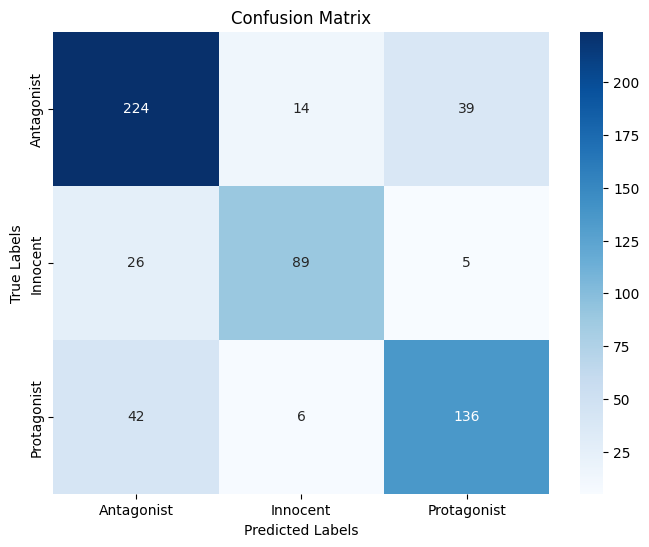

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Antagonist', 'Innocent', 'Protagonist'], yticklabels=['Antagonist', 'Innocent', 'Protagonist'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


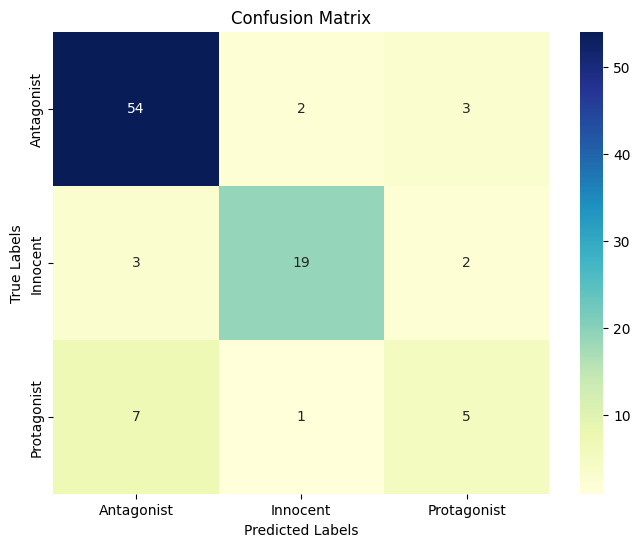

In [54]:

cm = confusion_matrix(bg_labels, bg_pred, labels=[0, 1, 2])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=['Antagonist', 'Innocent', 'Protagonist'], yticklabels=['Antagonist', 'Innocent', 'Protagonist'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

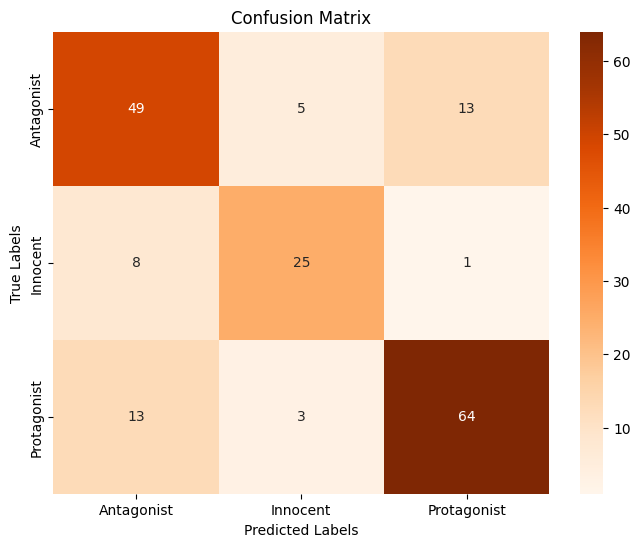

In [50]:

cm = confusion_matrix(hi_labels, hi_pred, labels=[0, 1, 2])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Antagonist', 'Innocent', 'Protagonist'], yticklabels=['Antagonist', 'Innocent', 'Protagonist'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

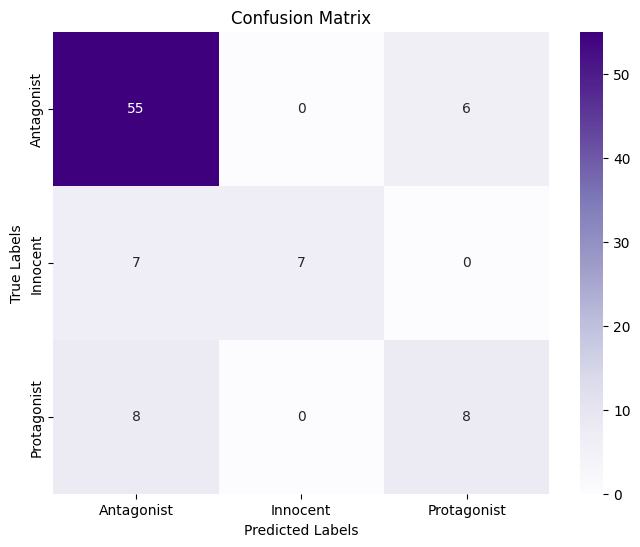

In [51]:
cm = confusion_matrix(en_labels, en_pred, labels=[0, 1, 2])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Antagonist', 'Innocent', 'Protagonist'], yticklabels=['Antagonist', 'Innocent', 'Protagonist'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

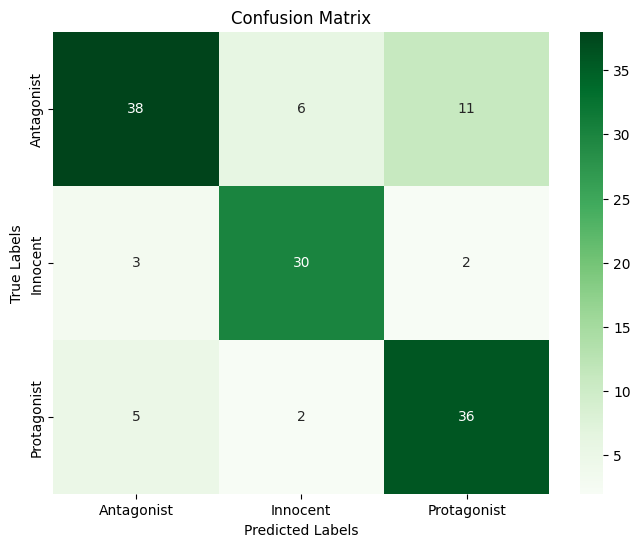

In [53]:
cm = confusion_matrix(pt_labels, pt_pred, labels=[0, 1, 2])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Antagonist', 'Innocent', 'Protagonist'], yticklabels=['Antagonist', 'Innocent', 'Protagonist'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

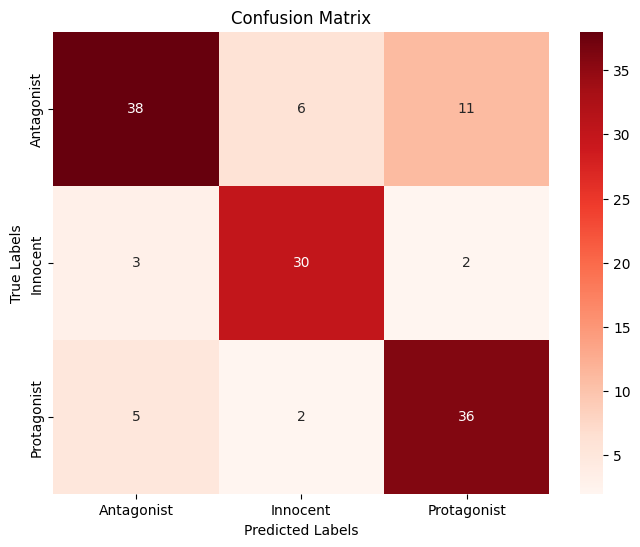

In [55]:
cm = confusion_matrix(pt_labels, pt_pred, labels=[0, 1, 2])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Antagonist', 'Innocent', 'Protagonist'], yticklabels=['Antagonist', 'Innocent', 'Protagonist'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()